## Code below for Content Image Generation

In [146]:
#Step 0 -- Create a pre-trained VGG16 model with last 3 FC layers removed 
#and pooling layer replaced with average pooling
from vgg16_avg import VGG16_Avg
model = VGG16_Avg(include_top=False)

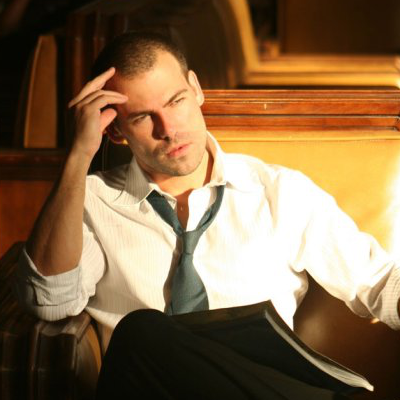

In [149]:
#Step 1 -- Load Content Image and Image Preprocessing
from utils2 import *
img = Image.open('JasonRidge.jpeg')
img = img.crop(box=(30,60,430,460))
img

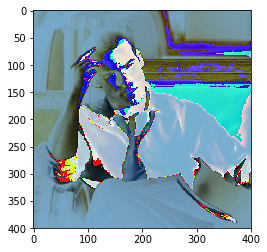

In [150]:
#Image Preprocessing -- Subtract mean value and convert from RGB to BGR to feed VGG16
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(img_arr))

In [155]:
#Step 2 -- Build Neural Network Graph (Model)
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
#We take the first Convolution output of the 5th also the last Convolution Block
#We can latet verify with earlier layer
layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

# Step 3 -- Build Neural Network Loss and Gradient (Optimization)
# Loss is a scalar value -- MSE
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
loss_fn = K.function([model.input], [loss])
grad_fn = K.function([model.input], grads)

# Create a container class for both Loss and Gradients
class Evaluator(object):
    def __init__(self, loss_f, grad_f, shp): 
        self.loss_f, self.grad_f, self.shp = loss_f, grad_f, shp
        
    def loss(self, x):
        loss_ = self.loss_f([x.reshape(self.shp)])
        return np.array(loss_).astype(np.float64)

    def grads(self, x): 
        grad_ = self.grad_f([x.reshape(self.shp)])
        return np.array(grad_).flatten().astype(np.float64)
evaluator = Evaluator(loss_fn, grad_fn, shp)


('Current loss value:', array([ 92.49624634]))
('Current loss value:', array([ 38.59172058]))
('Current loss value:', array([ 25.30461121]))
('Current loss value:', array([ 19.56064987]))
('Current loss value:', array([ 16.33964348]))
('Current loss value:', array([ 14.33158779]))
('Current loss value:', array([ 12.92133713]))
('Current loss value:', array([ 11.83940792]))
('Current loss value:', array([ 10.99672127]))
('Current loss value:', array([ 10.28565693]))


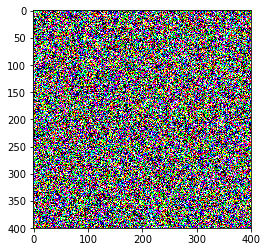

In [156]:
#Step 4 -- Time to Optimize 
#Define a method which will optimize (minimize) the Loss using L_BFGS algorithm
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/Content_gen_conv5_1_{i}.png'.format(i=i+1), deproc(x.copy(), shp)[0])
    return x

#Generate a random 'noise' image which will be the starting point of the optimization iteration
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(np.squeeze(x));
imsave('results/Content_gen_conv5_1_0.png',x[0])

#Start the optimization with 10 iterations
iterations = 10
x = solve_image(evaluator, iterations, x)

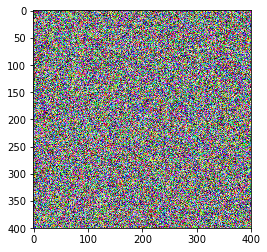

In [158]:
# Step 5 -- Visulization
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('results/Content_gen_conv5_1_{i}.png'.format(i=i)))

anim = animation.FuncAnimation(fig, animate, frames=iterations+1, interval=500)
HTML(anim.to_html5_video())

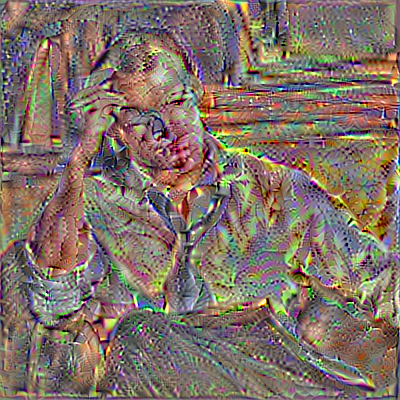

In [160]:
Image.open('results/Content_gen_conv5_1_9.png')

## Code below for Style Transfer

In [ ]:
from vgg16_avg import VGG16_Avg
from utils2 import *
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

%matplotlib inline
import matplotlib.pyplot as plt

# Step 1 -- Load Style and Content Images
# Load Style Image
style = Image.open('flower.jpg')
w,h = style.size
plt.imshow(np.array(style))

# Load Content Image and Crop it to the same size as the Style Image
content =Image.open('JasonRidge.jpeg');
content = content.crop(box=(30,30,30+w,30+h))
plt.imshow(np.array(content))

# Image Preprocessing for VGG16 - Substract mean value and convert from RGB to BGR
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

style_arr = preproc(np.expand_dims(np.array(style),0)[:,:,:,:3])
content_arr = preproc(np.expand_dims(np.array(content),0)[:,:,:,:3])
shp = style_arr.shape


# Step 2 -- Build Neural Network Graph (Model)
# First load a VGG16 pre-trained netowrk with the last 3 FC layers removed; 
# And make the input shape the same as Style/Content Images
model = VGG16_Avg(include_top=False, input_shape=shp[1:])

# Then build the tailored models for Style and Content Images respectively
outputs = {l.name: l.output for l in model.layers}
# We use all 5 Convolution Block Output in building Style Image Model
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

# We use only the 3rd Convolution Block Output in building Content Image Model
# in the hope that Content can be well preserved 
content_name = 'block3_conv2'
content_layer = outputs[content_name]
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(content_arr))


# Step 3 -- Build Neural Network Loss and Gradient (Optimization)
# First create a fucntion to calculate the Gram Matrix for Style Loss
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

# Style Loss is a scalar
style_wgts = [0.05,0.2,0.2,0.25,0.3]
loss_sty = sum(style_loss(l1[0], l2[0])*w for l1,l2,w in zip(style_layers, style_targs, style_wgts))

# Content Loss is a scalar
loss_con =  metrics.mse(content_layer, content_targ)

# Total Loss is the linear sum of Style Loss and Content Loss
# But here the denominator 10 is just used to balance whether 
# Style or Content is more emphasized
loss = loss_sty + loss_con/10

# K.gradients = tf.contrib.keras.backend.gradients
grads = K.gradients(loss, model.input)

# K.function = tf.contrib.keras.backend.function
# Note that loss_fn will return a scalar Loss while grad_fn a numpy array Gradients
loss_fn = K.function([model.input], [loss])
grad_fn = K.function([model.input], grads)

# Create a container class for both Loss and Gradients
class Evaluator(object):
    def __init__(self, loss_f, grad_f, shp): 
        self.loss_f, self.grad_f, self.shp = loss_f, grad_f, shp
        
    def loss(self, x):
        loss_ = self.loss_f([x.reshape(self.shp)])
        return np.array(loss_).astype(np.float64)

    def grads(self, x): 
        grad_ = self.grad_f([x.reshape(self.shp)])
        return np.array(grad_).flatten().astype(np.float64)
evaluator = Evaluator(loss_fn, grad_fn, shp)


# Step 4 -- Time to Optimize 
# Create a blank Image as the starting point, which is in the same size of Stype/Content Images
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)

# Define a method which will optimize (minimize) the Loss using L_BFGS algorithm
def solve_image(eval_obj, n_iter, x):
    for i in range(n_iter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/starry_night_conv3_at_iteration_{i}.png'.format(i=i), deproc(x.copy(), shp)[0])
    return x

# Now start the Optimization Iteration
iterations = 10
x = solve_image(evaluator, iterations, x)

# Step 5 -- Visulization
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('results/starry_night_conv3_at_iteration_{i}.png'.format(i=i)))

anim = animation.FuncAnimation(fig, animate, frames=iterations, interval=300)
HTML(anim.to_html5_video())

(1, 400, 400, 3)


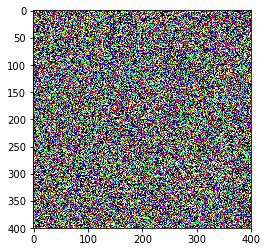

In [154]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(np.squeeze(x));
print x.shape


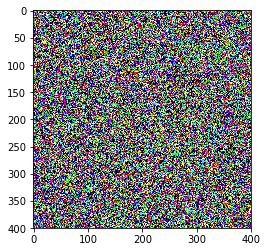

In [81]:







# Create Blank Image
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(np.squeeze(x));

# Build Optimization Model
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

layer = model.get_layer('block5_conv1').output
layer_model = Model(model.input, layer)

targ = K.variable(layer_model.predict(img_arr))

class Evaluator(object):
    def __init__(self, loss_f, grad_f, shp): self.loss_f, self.grad_f, self.shp = loss_f, grad_f, shp
        
    def loss(self, x):
        loss_ = self.loss_f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): 
        grad_ = self.grad_f([x.reshape(self.shp)])
        return grad_.astype(np.float64)

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
loss_fn = K.function([model.input], [loss])
grad_fn = K.function([model.input], grads)
evaluator = Evaluator(loss_fn,grad_fn, shp)

def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/res_at_iteration_{i}.png'.format(i=i), deproc(x.copy(), shp)[0])
    return x

# Optimization
iterations = 5
x = solve_image(evaluator, iterations, x)

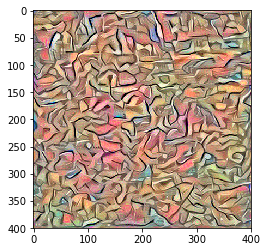

In [99]:
# Visulize the optimization performance
from IPython.display import HTML
from matplotlib import animation, rc
from utils2 import *
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('results/res_at_iteration_{i}.png'.format(i=i+1)))

anim = animation.FuncAnimation(fig, animate, frames=29, interval=300)
HTML(anim.to_html5_video())

(1, 400, 400, 3)
('Current loss value:', 10798.84375)
('Current loss value:', 1938.314453125)
('Current loss value:', 532.1314697265625)
('Current loss value:', 231.56980895996094)
('Current loss value:', 117.27771759033203)


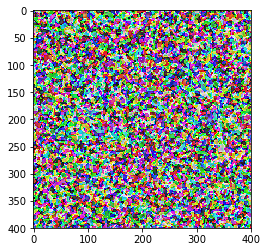

In [82]:
# Load Style Image
style = Image.open('style.jpg')
style = style.crop(box=(30,60,430,460))
#style = style.resize(np.divide(style.size,2.0).astype('int32')); 

# Image preprocessing for VGG16
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

style_arr = preproc(np.expand_dims(np.array(style),0)[:,:,:,:3])
shp = style_arr.shape

plt.imshow(np.squeeze(style_arr))

# Create Blank Image
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
plt.imshow(np.squeeze(x))

# Build Optimization Model
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {l.name: l.output for l in model.layers}

layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

# Optimization
iterations = 5
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x
x = solve_image(evaluator, iterations, x)

(1, 400, 400, 3)


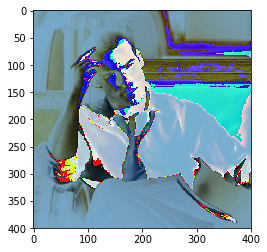

In [88]:
w,h = style.size
src = img_arr[:,:h,:w]
plt.imshow(np.squeeze(src))

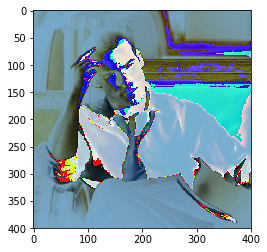

In [114]:
# Get the Origianl preprocessed and cropped Image 
w,h = style.size
src = img_arr[:,:h,:w]
plt.imshow(np.squeeze(src))

# Build the Optimization Model for Style Transfer
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block2_conv2'
content_layer = outputs[content_name]

style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

style_wgts = [0.05,0.2,0.2,0.25,0.3]
loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
loss_fn = K.function([model.input], [loss])
grad_fn = K.function([model.input], grads)

class Evaluator(object):
    def __init__(self, loss_f, grad_f, shp): 
        self.loss_f, self.grad_f, self.shp = loss_f, grad_f, shp
        
    def loss(self, x):
        loss_ = self.loss_f([x.reshape(self.shp)])
        return np.array(loss_).astype(np.float64)

    def grads(self, x): 
        grad_ = self.grad_f([x.reshape(self.shp)])
        return np.array(grad_).flatten().astype(np.float64)
    
evaluator = Evaluator(loss_fn, grad_fn, shp)


# Optimization
#iterations=10
#x = rand_img(shp)
#x = solve_image(evaluator, iterations, x)

In [115]:
x = rand_img(shp)
iterations=2
x = solve_image(evaluator, iterations, x)

('Current loss value:', array([ 24249.06640625]))
('Current loss value:', array([ 12961.921875]))


In [93]:
def solve_image_tmp2(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/res2_at_iteration_{i}.png'.format(i=i), deproc(x.copy(), shp)[0])
    return x
iterations=10
x = solve_image_tmp2(evaluator, iterations, x)

('Current loss value:', 1844.3602294921875)
('Current loss value:', 1767.0654296875)
('Current loss value:', 1713.6746826171875)
('Current loss value:', 1672.387939453125)
('Current loss value:', 1634.8851318359375)
('Current loss value:', 1600.926513671875)
('Current loss value:', 1568.1611328125)
('Current loss value:', 1545.29443359375)
('Current loss value:', 1525.4085693359375)
('Current loss value:', 1499.1920166015625)


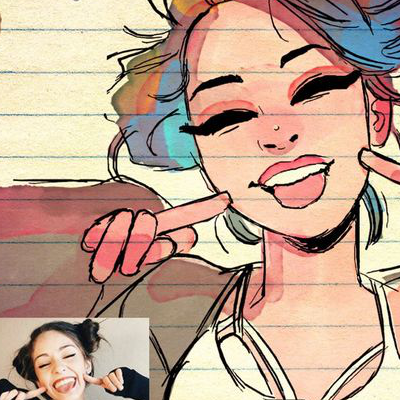

In [73]:
# Load Style Image
content = Image.open('JasonRidge.jpeg')
content = content.crop(box=(30,60,430,460))
content

style = Image.open('style.jpg')
style = style.crop(box=(30,60,430,460))
style
#print(np.array(style).shape)
#style = style.resize(np.divide(style.size,2.0).astype('int32')); 
#np.array(style).shape

In [ ]:
from utils import load_image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

img = load_image('bird.png')
#img = img.reshape((1, 224, 224, 3))
plt.imshow(np.squeeze(img))

In [ ]:
import skimage
import skimage.io
import skimage.transform
img = skimage.io.imread('bird.png')

In [ ]:
import tensorflow as tf
img = img.reshape((1, 224, 224, 3))
rgb_scaled = img * 255.0
VGG_MEAN = [103.939, 116.779, 123.68]
# Convert RGB to BGR
red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
assert red.get_shape().as_list()[1:] == [224, 224, 1]
assert green.get_shape().as_list()[1:] == [224, 224, 1]
assert blue.get_shape().as_list()[1:] == [224, 224, 1]
bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
print(bgr)

In [ ]:
sess = tf.Session()
with sess.as_default():
    print(bgr.eval())
    plt.imshow(bgr.eval()[0])

In [ ]:
from utils2 import *
img2=Image.open('bird.png');img2

In [ ]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
img_arr = preproc(np.expand_dims(np.array(img2), 0))
img_arr

In [ ]:

plt.imshow(np.squeeze(img_arr))

In [ ]:
np.mean(np.array(img2))

In [ ]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

img_arr = preproc(img)
shp = img_arr.shape
plt.imshow(np.squeeze(img_arr))

In [ ]:
img_res = deproc(img_arr,shp)[0]
plt.imshow(np.squeeze(img_res))


In [ ]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from utils2 import *

layer = model.get_layer('block2_conv1').output
layer_model = Model(model.input, layer)


targ = K.variable(layer_model.predict(img_arr))

class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        #x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/res_at_iteration_{i}.png'.format(i=i), deproc(x.copy(), shp)[0])
    return x

In [ ]:
rand_img = lambda shape: np.random.uniform(-1.0, 1.0, shape)
x = rand_img(shp)
plt.imshow(x[0]);

In [ ]:
info

In [ ]:
iterations = 10
x = solve_image(evaluator, iterations, x)

In [ ]:
Image.open('results/res_at_iteration_{i}.png')

In [ ]:
print('results/res_at_iteration_{i}.png'.format(i=1))

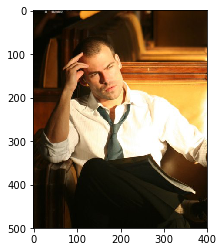

In [143]:
style = Image.open('flower.jpg')
w,h = style.size
plt.imshow(np.array(style))

# Load Content Image and Crop it to the same size as the Style Image
content =Image.open('JasonRidge.jpeg');
content = content.crop(box=(30,30,30+w,30+h))
plt.imshow(np.array(content))

('Current loss value:', array([ 17860.015625]))
('Current loss value:', array([ 10326.55078125]))
('Current loss value:', array([ 8721.44726562]))
('Current loss value:', array([ 8075.22509766]))
('Current loss value:', array([ 7711.6796875]))
('Current loss value:', array([ 7489.046875]))
('Current loss value:', array([ 7353.04248047]))
('Current loss value:', array([ 7267.42236328]))
('Current loss value:', array([ 7195.34130859]))
('Current loss value:', array([ 7150.90966797]))


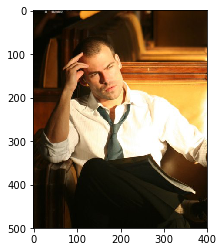

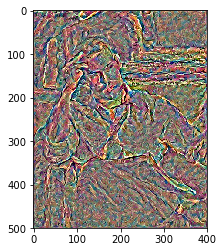

In [145]:
from vgg16_avg import VGG16_Avg
from utils2 import *
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

%matplotlib inline
import matplotlib.pyplot as plt

# Step 1 -- Load Style and Content Images
# Load Style Image
style = Image.open('flower.jpg')
w,h = style.size
plt.imshow(np.array(style))

# Load Content Image and Crop it to the same size as the Style Image
content =Image.open('JasonRidge.jpeg');
content = content.crop(box=(30,30,30+w,30+h))
plt.imshow(np.array(content))

# Image Preprocessing for VGG16 - Substract mean value and convert from RGB to BGR
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

style_arr = preproc(np.expand_dims(np.array(style),0)[:,:,:,:3])
content_arr = preproc(np.expand_dims(np.array(content),0)[:,:,:,:3])
shp = style_arr.shape


# Step 2 -- Build Neural Network Graph (Model)
# First load a VGG16 pre-trained netowrk with the last 3 FC layers removed; 
# And make the input shape the same as Style/Content Images
model = VGG16_Avg(include_top=False, input_shape=shp[1:])

# Then build the tailored models for Style and Content Images respectively
outputs = {l.name: l.output for l in model.layers}
# We use all 5 Convolution Block Output in building Style Image Model
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

# We use only the 3rd Convolution Block Output in building Content Image Model
# in the hope that Content can be well preserved 
content_name = 'block3_conv2'
content_layer = outputs[content_name]
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(content_arr))


# Step 3 -- Build Neural Network Loss and Gradient (Optimization)
# First create a fucntion to calculate the Gram Matrix for Style Loss
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

# Style Loss is a scalar
style_wgts = [0.05,0.2,0.2,0.25,0.3]
loss_sty = sum(style_loss(l1[0], l2[0])*w for l1,l2,w in zip(style_layers, style_targs, style_wgts))

# Content Loss is a scalar
loss_con =  metrics.mse(content_layer, content_targ)

# Total Loss is the linear sum of Style Loss and Content Loss
# But here the denominator 10 is just used to balance whether 
# Style or Content is more emphasized
loss = loss_sty + loss_con/10

# K.gradients = tf.contrib.keras.backend.gradients
grads = K.gradients(loss, model.input)

# K.function = tf.contrib.keras.backend.function
# Note that loss_fn will return a scalar Loss while grad_fn a numpy array Gradients
loss_fn = K.function([model.input], [loss])
grad_fn = K.function([model.input], grads)

# Create a container class for both Loss and Gradients
class Evaluator(object):
    def __init__(self, loss_f, grad_f, shp): 
        self.loss_f, self.grad_f, self.shp = loss_f, grad_f, shp
        
    def loss(self, x):
        loss_ = self.loss_f([x.reshape(self.shp)])
        return np.array(loss_).astype(np.float64)

    def grads(self, x): 
        grad_ = self.grad_f([x.reshape(self.shp)])
        return np.array(grad_).flatten().astype(np.float64)
evaluator = Evaluator(loss_fn, grad_fn, shp)


# Step 4 -- Time to Optimize 
# Create a blank Image as the starting point, which is in the same size of Stype/Content Images
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)

# Define a method which will optimize (minimize) the Loss using L_BFGS algorithm
def solve_image(eval_obj, n_iter, x):
    for i in range(n_iter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave('results/starry_night_conv3_at_iteration_{i}.png'.format(i=i), deproc(x.copy(), shp)[0])
    return x

# Now start the Optimization Iteration
iterations = 10
x = solve_image(evaluator, iterations, x)

# Step 5 -- Visulization
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('results/starry_night_conv3_at_iteration_{i}.png'.format(i=i)))

anim = animation.FuncAnimation(fig, animate, frames=iterations, interval=300)
HTML(anim.to_html5_video())

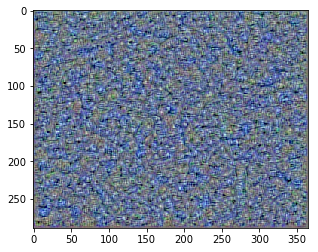

In [139]:
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('results/starry_night_at_iteration_{i}.png'.format(i=i)))

anim = animation.FuncAnimation(fig, animate, frames=10, interval=300)
HTML(anim.to_html5_video())

In [129]:
print(style.size)

(365, 289)


(289, 365, 3)
(365, 289)


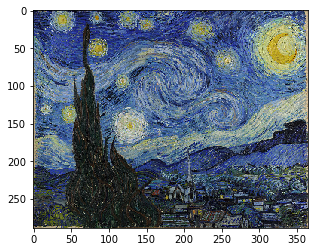

In [126]:
# Style Image
style = Image.open('starnight.png')
print (np.array(style).shape)
w,h = style.size
print (w,h)
plt.imshow(np.array(style))

#style = style.crop(box=(30,60,430,460))
#style = style.resize(np.divide(style.size,2.0).astype('int32')); 

# Image preprocessing for VGG16
#style_arr = preproc(np.expand_dims(np.array(style),0)[:,:,:,:3])
#shp = style_arr.shape

#plt.imshow(np.squeeze(style_arr))